In [1]:
import re
import pickle
from pathlib import Path
from multiprocessing import Pool
import json

import requests
from bs4 import BeautifulSoup

class Element:
    def __init__(self, url):
        self.url = url
    
    def get_url(self):
        return Element.convert_url(self.url)
        
    def convert_url(relative_url):
        return 'https://en.wikinews.org{}'.format(relative_url)

    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        return '"{}"'.format(self.url)
    
class Article(Element):
    def __init__(self, url, name=None, categories=[]):
        super().__init__(url)
        
        if name is not None:
            self.name = name.strip()
            self.categories = categories
        else:
            self.name, self.categories = Article.parse(url)
    
    def is_meaningfull(self):
        if not self.url.startswith('/wiki/'):
            return False

        if self.name.startswith('Template') \
        or self.name.startswith('Portal') \
        or self.name.startswith('User') \
        or self.name.startswith('Talk') \
        or self.name.startswith('Help') \
        or self.name.startswith('TEST') \
        or self.name.startswith('Category') \
        or self.name.startswith('Module') \
        or self.name.startswith('News'):
            return False

        if 'Wikinews' in self.name:
            return False

        return True

    def parse(url):    
        json_url = "https://en.wikinews.org/w/api.php?action=query&titles={}&prop=categories&format=json".format(
            url[6:]
        )
        
        response = json.loads(requests.get(json_url, timeout=5).content)
        pages = response['query']['pages']
        if len(pages) != 1:
            raise ""
        page = next(iter(pages.values()))
        
        categories = page['categories'] if 'categories' in page else []
        return page['title'], [category['title'][9:] for category in categories]
            
    def __str__(self):
        return '"{}"'.format(self.name)
        
class Category(Element):
    def __init__(self, url, name=None, sub_categories=[], articles=[]):
        super().__init__(url)
        self.name = name
        self.sub_categories = sub_categories
        self.articles = articles
    
    def parse(self, articles_cache, categories_cache, check_article=True, check_categories=True):
        page_html = requests.get(self.get_url(), timeout=5)
        page_content = BeautifulSoup(page_html.content, "html.parser")

        if self.name is None:
            title_element = page_content.find('h1')
            if title_element is not None:
                self.name = title_element.text[9:].strip()
                
        # Parse and add unknown articles
        mw_pages = page_content.find('div', {"id": "mw-pages"})
        if mw_pages is not None:
            article_candidates = [Article(name=article.text, url=article['href']) for article in mw_pages.findAll('a')]
            articles = {
                article.url: article
                for article in article_candidates
                if (not check_article) or article.is_meaningfull()
            }
            articles_cache.update(articles)
        
            # Add childs
            self.articles = list(articles.keys())
        
        mw_subcategories = page_content.find('div', {"id": "mw-subcategories"})
        if mw_subcategories is not None:
            self.sub_categories = [
                category['href']
                for category in mw_subcategories.findAll('a')
                if (not check_categories) or category['href'] in categories_cache
            ]
            
            if not check_categories:
                new_categories = [
                    Category(category_url) for category_url in self.sub_categories 
                    if category_url not in categories_cache
                ]
                
                categories_cache.update({
                    category.url: category 
                    for category in new_categories 
                    if category.parse(articles_cache, categories_cache, check_article, check_categories)
                })
            
        return True
    
    def from_urls(categories):
        articles_tmp = {}
        categories_tmp = {}
        return [
            category 
            for category in (Category(category) for category in categories)
            if category.parse(articles_tmp, categories_tmp, False, False)
        ], categories_tmp, articles_tmp
            
    def from_wikinews(limit = 2000, num_categories=-1):
        WIKINEWS = "http://en.wikinews.org/w/index.php?title=Special:Categories&limit={}&offset={}"

        category_detector = re.compile('\/wiki\/Category:.+')
        number_detector = re.compile('\(([0-9,]+) ')
        categories = []

        while (num_categories == -1 or len(categories) < num_categories):
            url = WIKINEWS.format(limit, categories[-1].url[15:] if len(categories) > 0 else '')
            page_response = requests.get(url, timeout=5)
            page_content = BeautifulSoup(page_response.content, "html.parser").find('div', {"class": "mw-spcontent"})

            for candidate in page_content.find_all('a', {"href": category_detector}):
                num_childs = int(number_detector.search(candidate.parent.text).group(1).replace(',', ''))
                if num_childs > 0:
                    categories.append(Category(url=candidate['href']))

            if page_content.find('a', {'class':'mw-nextlink'}) is None:
                break

        return { category.url : category for category in categories }

    def filter_categories(categories, min_articles):
        date_regex = re.compile('^((January)|(February)|(March)|(April)|(May)|(June)|(July)|(August)|(September)|(October)|(November)|(December))')
        year_regex = re.compile('^[0-9]{4}$')
        wiki_regex = re.compile('.*[w|W]iki.*')
        wiki_other_noise = ["archived", "dialog ", "files", "sockpuppets", "sources", 
             "requests for", "peer reviewed", "non-", "articles", "media", 
             "categor", "cc", "assistant", "pages", "checkuser", "template", 
             "wwc", "failed", "abandoned", "local", "live", "wikinewsie", 
             "user", "uow", "no publish", "published", "autoarchived", 
             "original reporting", "audio reports", "out of date stories", 
             "news of the world", "writing contest", "source offline", "photo essays", 
             "football match reports"
        ]
        
        filtered = {
            key: value for key, value in categories.items() 
            if not date_regex.match(key) 
            and not year_regex.match(key) 
            and not wiki_regex.match(key) 
            and not any(True for phase in wiki_other_noise if phase in key.lower())
        }

        filtered = {key: value for key, value in filtered.items() if len(value) >= min_articles}
        return filtered

    def __str__(self):
        return '"{}":\n\tArticles: {}\n\tSubcategories: {}\n'.format(self.name, self.articles, self.sub_categories)

In [2]:
from knowledgestore import ks
from collections import defaultdict

def articles_to_categories(articles):
    categories = defaultdict(set)
    for article in articles:
        for category in article.categories:
            categories[category].add(article)
    return categories

def create_article(link):
    return Article(link[22:])

FILE_CACHE = Path("articles.pickle")
if not FILE_CACHE.exists():
    print("Generating articles for KnowledgeStore")
    with Pool(6) as pool:
        articles = pool.map(create_article, ks.get_all_resource_uris())
    with open(FILE_CACHE, "wb") as file:
        pickle.dump(articles, file)
else:
    with open(FILE_CACHE, "rb") as file:
        articles = pickle.load(file)
    
print("{} articles loaded".format(len(articles)))

categories = articles_to_categories(articles)
print("Categories before filtering: \t", len(categories))

filtered_categories = Category.filter_categories(categories, 0)
print("Categories after filtering: \t", len(filtered_categories))

filtered_categories_min_size = Category.filter_categories(categories, 5)
print("Categories after filtering for size: \t", len(filtered_categories_min_size))

19737 articles loaded
Categories before filtering: 	 5833
Categories after filtering: 	 2374
Categories after filtering for size: 	 1589


Plotting the distribution of categories:

In [3]:
from matplotlib import pyplot
import seaborn as sbs
import numpy as np

occurences = [(key, len(value)) for key, value in filtered_categories.items()]
occurences.sort(key=lambda x: x[1], reverse=True)

num_articles = np.array([category[1] for category in occurences])
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
dist = sbs.distplot(num_articles, hist=False, norm_hist=False, ax=ax)
dist.set_xlabel('Number of articles per category (log)')
dist.set_ylabel('Relative number of categories')
dist.set_xscale("log")
dist.set_title("Distibution of articles")
dist.set_xlim(0)

(36.018314010800324, 7176.1420007604393)

Plotting the different categories:

(-0.5, 399.5, 199.5, -0.5)

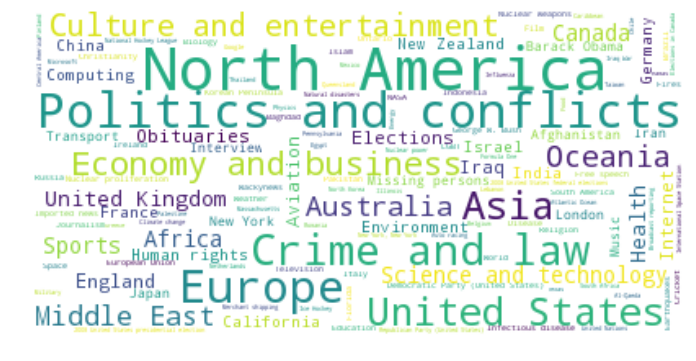

In [4]:
from wordcloud import WordCloud

top_occurences = { name: occurences for name, occurences in occurences }
sum_occurences = sum(top_occurences.values())
top_occurences = {name: occurences / sum_occurences for name, occurences in top_occurences.items()}

cloud = WordCloud(background_color="white").fit_words(top_occurences)

fig, ax = pyplot.subplots(figsize=(11.7, 8.27))
ax.imshow(cloud, interpolation="bilinear")
ax.axis("off")

In [5]:
import random
import pandas as pd

class Representation:
    class Parameter:
        def __init__(self, num_articles_per_interest, num_positive_samples, num_negative_samples):
            self.num_articles_per_interest = num_articles_per_interest
            self.num_positive_samples = num_positive_samples
            self.num_negative_samples = num_negative_samples
            
        def generate(self, interests, user_interests):
            interesting_category = [
                random.sample(interests[interest], self.num_articles_per_interest + self.num_positive_samples) 
                for interest in user_interests
            ]
            
            read_articles = []
            positive_samples = []
            negative_samples = []
            for interesting_article in interesting_category:
                read_articles.extend(interesting_article[self.num_positive_samples:])
                positive_samples.extend(interesting_article[:self.num_positive_samples])
                
            while len(negative_samples) < self.num_negative_samples:
                negative_category = random.choice(tuple(interests.keys()))
                if negative_category not in user_interests:
                    candidates = set(interests[negative_category])
                    for user_interest in user_interests:
                        candidates = candidates.difference(interests[user_interest])
                    
                    if len(candidates) + len(negative_samples) <= self.num_positive_samples:
                        negative_samples.extend(candidates)
                    elif len(candidates) > 0:                        
                        limit = self.num_negative_samples - len(negative_samples)
                        negative_samples.extend((c for i, c in enumerate(candidates) if i < limit))
            
            assert len(positive_samples) == self.num_positive_samples * len(user_interests), "Invalid number of positiv samples"
            assert len(negative_samples) == self.num_negative_samples, "Invalid number of negativ samples"
            return Representation(
                articles=read_articles, 
                positive_samples=positive_samples, 
                negative_samples=negative_samples
            )
            
    def __init__(self, articles, positive_samples, negative_samples):
        self.articles = articles
        self.positive_samples = positive_samples
        self.negative_samples = negative_samples
        
    def __str__(self):
        return "Articles: {}\n -> Interesting: {}\n -> Not interesting: {}".format(
            self.articles,
            self.positive_samples,
            self.negative_samples
        )
    
    def rows(self):
        for positive_sample in self.positive_samples:
            yield [self.articles, positive_sample, True]
        for negative_sample in self.negative_samples:
            yield [self.articles, negative_sample, False]
    
class User:
    class Parameter:
        def __init__(self, representation_params, num_interests, num_representations):
            self.num_interests  = num_interests
            self.num_representations = num_representations
            self.representation_params = representation_params
            
        def generate(self, interests):
            user_interests = random.sample(interests.keys(), self.num_interests)
            representations = [
                self.representation_params.generate(interests, user_interests)
                for _ in range(self.num_representations)
            ]
            return User(interests=user_interests, representations=representations)
        
    def __init__(self, interests, representations):
        self.interests = interests
        self.representations = representations
        
    def __str__(self):
        return "User with {} interests ({} representations): {}".format(
            len(self.interests),
            len(self.representations),
            self.interests
        )
    
    def rows(self):
        for representation in self.representations:
            for row in representation.rows():
                yield [self.interests] + row

class DataSet:
    class Parameter:
        def __init__(self, user_params, num_user):
            self.user_params = user_params
            self.num_user = num_user
            
        def generate(self, interests):
            return DataSet(
                [self.user_params.generate(interests) for _ in range(self.num_user)],
                self
            )
            
    def __init__(self, users, hyperparameters):
        self.users = users
        self.params = hyperparameters
        
    def __str__(self):
        return "Dataset with {} users.".format(len(self.users))
    
    def save(self, path):
        with open(path, "wb") as file:
            pickle.dump(self, file)
    
    def load(path):
        with open(path, "rb") as file:
            return pickle.load(file)
        
    def as_dataframe(self):
        column_names = [
            "interest_{}".format(i)
            for i in range( 
                self.params.user_params.num_interests
            )
        ] + [
            "article_{}".format(i)
            for i in range(
                self.params.user_params.representation_params.num_articles_per_interest * 
                self.params.user_params.num_interests
            )
        ] + ["candidate", "label"]
        
        return pd.DataFrame.from_records((
            [str(interest) for interest in interests] + 
            [article.url for article in articles] + 
            [candidate.url] + 
            [label]
            for user in self.users 
            for interests, articles, candidate, label in user.rows()
        ), columns=column_names)
        

dataset_params = DataSet.Parameter(
    user_params=User.Parameter(
        representation_params=Representation.Parameter(
            num_articles_per_interest=3, 
            num_positive_samples=1, 
            num_negative_samples=2
        ), 
        num_interests=2, 
        num_representations=2
    ),
    num_user=100
)

dataset = dataset_params.generate(filtered_categories_min_size)
dataset.as_dataframe()

,interest_0,interest_1,article_0,article_1,article_2,article_3,article_4,article_5,candidate,label
0,Red Cross and Red Crescent,Radovan Karadžić,/wiki/Trapped_journalists_in_Libya_freed,"/wiki/85_rescued,_thousands_feared_dead_in_Phi...","/wiki/Two_killed,_two_seriously_injured_after_...",/wiki/Tense_panel_discussion_on_Srebrenica_hel...,/wiki/Remembering_Srebrenice_massacre,/wiki/Alleged_war_criminal_Radovan_Karad%c5%be...,/wiki/Amnesty_International_calls_for_Guantana...,True
1,Red Cross and Red Crescent,Radovan Karadžić,/wiki/Trapped_journalists_in_Libya_freed,"/wiki/85_rescued,_thousands_feared_dead_in_Phi...","/wiki/Two_killed,_two_seriously_injured_after_...",/wiki/Tense_panel_discussion_on_Srebrenica_hel...,/wiki/Remembering_Srebrenice_massacre,/wiki/Alleged_war_criminal_Radovan_Karad%c5%be...,/wiki/Ex-Bosnian_Serb_leader:_Alleged_war_crim...,True
2,Red Cross and Red Crescent,Radovan Karadžić,/wiki/Trapped_journalists_in_Libya_freed,"/wiki/85_rescued,_thousands_feared_dead_in_Phi...","/wiki/Two_killed,_two_seriously_injured_after_...",/wiki/Tense_panel_discussion_on_Srebrenica_hel...,/wiki/Remembering_Srebrenice_massacre,/wiki/Alleged_war_criminal_Radovan_Karad%c5%be...,/wiki/Bones_of_'small-bodied_humans'_found_in_...,False
3,Red Cross and Red Crescent,Radovan Karadžić,/wiki/Trapped_journalists_in_Libya_freed,"/wiki/85_rescued,_thousands_feared_dead_in_Phi...","/wiki/Two_killed,_two_seriously_injured_after_...",/wiki/Tense_panel_discussion_on_Srebrenica_hel...,/wiki/Remembering_Srebrenice_massacre,/wiki/Alleged_war_criminal_Radovan_Karad%c5%be...,/wiki/Pakistan_successfully_tests_cruise_missile,False
4,Red Cross and Red Crescent,Radovan Karadžić,/wiki/Amnesty_International_calls_for_Guantana...,/wiki/An_account_of_the_Esperanza_Fire_from_an...,/wiki/Red_Cross_is_not_in_New_Orleans_for_Katr...,/wiki/Alleged_war_criminal_Radovan_Karad%c5%be...,/wiki/Ex-Bosnian_Serb_leader:_Alleged_war_crim...,/wiki/Remembering_Srebrenice_massacre,"/wiki/Highway_bridge_in_Minneapolis,_Minnesota...",True
5,Red Cross and Red Crescent,Radovan Karadžić,/wiki/Amnesty_International_calls_for_Guantana...,/wiki/An_account_of_the_Esperanza_Fire_from_an...,/wiki/Red_Cross_is_not_in_New_Orleans_for_Katr...,/wiki/Alleged_war_criminal_Radovan_Karad%c5%be...,/wiki/Ex-Bosnian_Serb_leader:_Alleged_war_crim...,/wiki/Remembering_Srebrenice_massacre,/wiki/Bosnian_administrator_outlines_plans,True
6,Red Cross and Red Crescent,Radovan Karadžić,/wiki/Amnesty_International_calls_for_Guantana...,/wiki/An_account_of_the_Esperanza_Fire_from_an...,/wiki/Red_Cross_is_not_in_New_Orleans_for_Katr...,/wiki/Alleged_war_criminal_Radovan_Karad%c5%be...,/wiki/Ex-Bosnian_Serb_leader:_Alleged_war_crim...,/wiki/Remembering_Srebrenice_massacre,/wiki/Foxconn_under_pressure_after_tenth_emplo...,False
7,Red Cross and Red Crescent,Radovan Karadžić,/wiki/Amnesty_International_calls_for_Guantana...,/wiki/An_account_of_the_Esperanza_Fire_from_an...,/wiki/Red_Cross_is_not_in_New_Orleans_for_Katr...,/wiki/Alleged_war_criminal_Radovan_Karad%c5%be...,/wiki/Ex-Bosnian_Serb_leader:_Alleged_war_crim...,/wiki/Remembering_Srebrenice_massacre,/wiki/Cutting_bonuses_and_management_is_Dell's...,False
8,British Columbia,Norway,/wiki/Suspect_in_model_Jasmine_Fiore's_murder_...,/wiki/British_Columbia_helicopter_crash_kills_4,/wiki/Truck_crashes_into_British_Columbia_wedd...,/wiki/Al_Gore_and_Climate_Panel_awarded_Nobel_...,/wiki/Mayor_of_Oslo_resigns_after_tax_fraud_sc...,/wiki/Zenit_rocket_launches_AMOS-3_satellite,/wiki/Canada_confirms_fifth_case_of_Mad_Cow_Di...,True
9,British Columbia,Norway,/wiki/Suspect_in_model_Jasmine_Fiore's_murder_...,/wiki/British_Columbia_helicopter_crash_kills_4,/wiki/Truck_crashes_into_British_Columbia_wedd...,/wiki/Al_Gore_and_Climate_Panel_awarded_Nobel_...,/wiki/Mayor_of_Oslo_resigns_after_tax_fraud_sc...,/wiki/Zenit_rocket_launches_AMOS-3_satellite,/wiki/Details_emerge_on_Norway_Rock_Festival_d...,True
